In [41]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, InputLayer
from keras.layers import SeparableConv1D
import statistics
from statistics import mode
import random
import os
from collections import Counter

import math

import pylab as p
import seaborn as sns
from datetime import datetime, timedelta
import string
from sklearn.preprocessing import OneHotEncoder

# Read and process data

### Calculate the power and put it in a dataframe

In [2]:
def calculate_power(LF1V, LF1I, TimeTicks1, LF2V, LF2I, TimeTicks2):
    LF1V = np.array(LF1V)
    LF1I = np.array(LF1I)
    LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
    LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

    LF2V = np.array(LF2V)
    LF2I = np.array(LF2I)
    LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
    LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

    L1_P = LF1V * np.conjugate(LF1I)
    L2_P = LF2V * np.conjugate(LF2I)

    L1_ComplexPower = np.sum(L1_P, axis=1)
    L2_ComplexPower = np.sum(L2_P, axis=1)

    L1_real = np.real(L1_ComplexPower)
    L1_imag = np.imag(L1_ComplexPower)
    L1_app = np.abs(L1_ComplexPower)

    L2_real = np.real(L2_ComplexPower)
    L2_imag = np.imag(L2_ComplexPower)
    L2_app = np.abs(L2_ComplexPower)

    L1_Pf = np.cos(np.angle(L1_P[:, 0]))
    L2_Pf = np.cos(np.angle(L2_P[:, 0]))

    L1_actual_power = L1_real * L1_Pf
    L2_actual_power = L2_real * L2_Pf

    time_ticks1 = np.array(TimeTicks1)
    time_ticks2 = np.array(TimeTicks2)

    data = pd.DataFrame()
    len = min(L1_actual_power.size, L2_actual_power.size)

    data["Phase1_actual"] = L1_actual_power[:len]
    data["Phase1_real"] = L1_real[:len]
    data["Phase1_img"] = L1_imag[:len]
    data["Phase1_app"] = L1_app[:len]
    data["Phase1_time"] = time_ticks1[:len]

    data["Phase2_actual"] = L2_actual_power[:len]
    data["Phase2_real"] = L2_real[:len]
    data["Phase2_img"] = L2_imag[:len]
    data["Phase2_app"] = L2_app[:len]
    data["Phase2_time"] = time_ticks2[:len]

    return data

### Go through directory and process the days

In [3]:
# Directory is the path to the directory where to house's information is
def read_files_in_directory(directory):
    all_tagging_info = pd.DataFrame()
    labels = []
    data = []

    for root, _, files in os.walk(directory):
        if "Testing" in root:
            continue

        LF1I = pd.DataFrame()
        LF1V = pd.DataFrame()
        TimeTicks1 = pd.DataFrame()
        LF2I = pd.DataFrame()
        LF2V = pd.DataFrame()
        TimeTicks2 = pd.DataFrame()
        for file in files:

            file_path = os.path.join(root, file)
            if file == "CompleteTaggingInfo.csv":
                all_tagging_info = pd.read_csv(file_path)
                continue

            if file == "TaggingInfo.csv":
                # labels.append(pd.read_csv(file_path))
                continue

            if file == "LF1I.csv":
                LF1I = pd.read_csv(file_path)
                continue

            if file == "LF1V.csv":
                LF1V = pd.read_csv(file_path)
                continue

            if file == "TimeTicks1.csv":
                TimeTicks1 = pd.read_csv(file_path)
                continue

            if file == "LF2I.csv":
                LF2I = pd.read_csv(file_path)
                continue

            if file == "LF2V.csv":
                LF2V = pd.read_csv(file_path)
                continue

            if file == "TimeTicks2.csv":
                TimeTicks2 = pd.read_csv(file_path)
                continue

        if not LF1I.empty and not LF1V.empty and not LF2I.empty and not LF2V.empty:
            print(f"{root}: ")
            day_data = calculate_power(LF1I, LF1V, TimeTicks1, LF2I, LF2V, TimeTicks2)
            data.append(day_data)

    return data, labels, all_tagging_info

In [4]:
data, _, all_tagging_info = read_files_in_directory(r".\dataset")

.\dataset\H1\Tagged_Training_04_13_1334300401: 
.\dataset\H1\Tagged_Training_10_22_1350889201: 
.\dataset\H1\Tagged_Training_10_23_1350975601: 
.\dataset\H1\Tagged_Training_10_24_1351062001: 
.\dataset\H1\Tagged_Training_10_25_1351148401: 
.\dataset\H1\Tagged_Training_12_27_1356595201: 
.\dataset\H2\Tagged_Training_02_15_1360915201: 
.\dataset\H2\Tagged_Training_06_13_1339570801: 
.\dataset\H2\Tagged_Training_06_14_1339657201: 
.\dataset\H2\Tagged_Training_06_15_1339743601: 
.\dataset\H3\Tagged_Training_07_30_1343631601: 
.\dataset\H3\Tagged_Training_07_31_1343718001: 
.\dataset\H3\Tagged_Training_08_01_1343804401: 
.\dataset\H4\Tagged_Training_07_26_1343286001: 
.\dataset\H4\Tagged_Training_07_27_1343372401: 


In [5]:
print(data)

[        Phase1_actual  Phase1_real  Phase1_img  Phase1_app   Phase1_time  \
0           19.430857    24.264125   18.475752   30.497560  1.334300e+09   
1           19.924720    24.357135   17.474827   29.977318  1.334300e+09   
2           19.690603    24.166927   17.523352   29.851436  1.334300e+09   
3           19.910825    24.234800   17.153411   29.691161  1.334300e+09   
4           20.829979    25.187723   17.446867   30.640081  1.334300e+09   
...               ...          ...         ...         ...           ...   
518938      19.939808    24.472770   17.732765   30.221969  1.334387e+09   
518939      19.792885    24.371436   17.809936   30.185439  1.334387e+09   
518940      20.446493    24.783498   17.294649   30.221295  1.334387e+09   
518941      20.235556    24.840667   18.001915   30.677804  1.334387e+09   
518942      19.618725    24.178684   17.711506   29.971757  1.334387e+09   

        Phase2_actual  Phase2_real  Phase2_img  Phase2_app   Phase2_time  
0          

# Next we need to detect all labeled events

### All the methods needed to detect, filter and extract spikes

In [23]:
def moving_average(array, window):
    moving_avg = np.convolve(array, np.ones(window) / window, mode='valid')
    return moving_avg


def normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array


def detect_cusum(array, threshold, drift):
    sum_positive = np.zeros(array.size)
    sum_negative = np.zeros(array.size)
    event_index_start = np.array([[], [], []], dtype=int)
    event_index_end = np.array([[], [], []], dtype=int)

    for i in range(1, array.size):
        sum = array[i] - array[i - 1]

        # sums for positive/negative changes
        sum_positive[i] = max(0, sum_positive[i - 1] + sum - drift)
        sum_negative[i] = max(0, sum_negative[i - 1] - sum - drift)

        # if a change is detected
        if sum_positive[i] > threshold:
            event_index_start = np.append(event_index_start, i)
            sum_positive[i], sum_negative[i] = 0, 0
            continue

        if sum_negative[i] > threshold:
            event_index_end = np.append(event_index_end, i)
            sum_positive[i], sum_negative[i] = 0, 0

    return event_index_start, event_index_end


def filter_close_events(event_indices, min_separation):
    filtered_indices = [event_indices[0]]

    for i in range(1, event_indices.size):
        if event_indices[i] - event_indices[i - 1] >= min_separation:
            # If the time separation is greater than or equal to the threshold, keep the event
            filtered_indices.append(event_indices[i])

    return np.array(filtered_indices)


# Short spikes in power when an appliance starts up can be detected as an end event, so make sure that start and end events are not too close together
def filter_spikes(events_start, events_end, min_separation):
    indexes_to_delete = list()

    for iter in range(4):
        for i in range(events_start.size):
            for j in range(events_end.size):
                if events_end[j] < events_start[i]:
                    continue

                if events_end[j] - events_start[i] < min_separation:
                    indexes_to_delete.append(j)
                    break

                break

        events_end = np.delete(events_end, indexes_to_delete)
        indexes_to_delete = list()
    return events_end


def group_start_end(events_start, events_end):
    start_indexes = list()
    end_indexes = list()

    for i in range(events_start.size):
        for j in range(events_end.size):
            if events_end[j] < events_start[i]:
                continue

            start_indexes.append(events_start[i])
            end_indexes.append(events_end[j])
            break

    return np.array(start_indexes), np.array(end_indexes)


def filter_short_events(events_start, events_end, min_event_length):
    start_indexes = list()
    end_indexes = list()

    for i in range(events_start.size):
        if events_end[i] - events_start[i] >= min_event_length:
            start_indexes.append(events_start[i])
            end_indexes.append(events_end[i])

    return np.array(start_indexes), np.array(end_indexes)


def calculate_overlap(start, end, on, off):
    return (min(end, off) - max(start, on)) / (end - start)


def find_closest_event(events_start, events_end, time_ticks, label):
    start = 0
    end = max(events_end)

    for event in range(events_start.size):
        if events_start[event] > start and time_ticks[int(events_start[event])] <= label["OnTime"]:
            start = events_start[event]

        if events_end[event] < end and time_ticks[int(events_end[event])] >= label["OffTime"]:
            end = events_end[event]

    return start, end


def extract_labeled_spikes(events_start, events_end, time_ticks, labels):
    labeled_events_start = list()
    labeled_events_end = list()
    event_labels = list()

    start_of_day = time_ticks[0][0]
    end_of_day = time_ticks[0][time_ticks[0].size - 1]

    for index in range(labels.shape[0]):
        row = labels.iloc[index]
        found = False

        if not (start_of_day <= row["OnTime"] <= end_of_day):
            continue

        last_event = 0
        phase_index = 0
        for event in range(events_start.size):
            start = int(events_start[event])
            end = int(events_end[event])

            if start < last_event:
                phase_index += 1

            last_event = start

            time = time_ticks[phase_index]

            if not (row["OnTime"] <= time[start] <= row["OffTime"] or row["OnTime"] <= time[end] <= row["OffTime"]):
                continue

            found = True
            overlap = calculate_overlap(time[start], time[end], row["OnTime"], row["OffTime"])
            if overlap < 0.3:
                continue

            labeled_events_start.append(start)
            labeled_events_end.append(end)
            event_labels.append(row["ID"])

        if not found:
            start, end = find_closest_event(events_start, events_end, time_ticks[phase_index], row)
            labeled_events_start.append(start)
            labeled_events_end.append(end)
            event_labels.append(row["ID"])

    return np.array(labeled_events_start), np.array(labeled_events_end), np.array(event_labels)


def calculate_events(phase_power):
    phase_power = moving_average(phase_power, 7)
    phase_power = normalize(phase_power)

    events_start, events_end = detect_cusum(phase_power, threshold=0.009, drift=0.0005)
    events_start = filter_close_events(events_start, 60)
    events_end = filter_close_events(events_end, 60)
    events_end = filter_spikes(events_start, events_end, 12)
    events_start, events_end = group_start_end(events_start, events_end)
    events_start, events_end = filter_short_events(events_start, events_end, 100)

    return events_start, events_end


def remove_overlapping_events(events_start, events_end, event_labels):
    to_remove = list()

    for index in range(1, events_start.size):
        if events_end[index] == events_end[index - 1]:
            to_remove.append(index)

    if event_labels.size != 0:
        event_labels = np.delete(event_labels, to_remove)
    return np.delete(events_start, to_remove), np.delete(events_end, to_remove), event_labels

In [7]:
def label_generalization(ids, general_labels):
    generalized_ids = np.empty(0)
    for id in ids:
        generalized_ids = np.append(generalized_ids,
                                    general_labels.loc[general_labels['ApplianceID'] == id, 'GeneralID'].unique()[0])
    return generalized_ids


def detect_day_events(dataframe, labels, general_tagging_info):
    phases = ["Phase1", "Phase2"]
    events_start = np.empty(0)
    events_end = np.empty(0)
    time_ticks = np.empty((2, len(dataframe)))
    events = list()
    i = 0

    for phase in phases:
        dataframe[phase + "_eOn"] = 0
        dataframe[phase + "_eOff"] = 0
        power = dataframe[phase + "_actual"]
        time = dataframe[phase + "_time"]

        events_start_temp, events_end_temp = calculate_events(power)
        events.append(events_start_temp)
        events_start = np.append(events_start, events_start_temp)
        events_end = np.append(events_end, events_end_temp)
        time_ticks[i] = time
        i += 1

    events_start, events_end, event_labels = extract_labeled_spikes(events_start, events_end, time_ticks, labels)
    events_start, events_end, event_labels = remove_overlapping_events(events_start, events_end, event_labels)
    event_labels = label_generalization(event_labels, general_tagging_info)

    phase = "Phase1"
    for index in range(events_start.size):
        if events_start[index] in events[0]:
            phase = "Phase1"
        else:
            phase = "Phase2"

        dataframe.loc[events_start[index], phase + "_eOn"] = event_labels[index]
        dataframe.loc[events_end[index], phase + "_eOff"] = event_labels[index]

    return dataframe

### Edit dataframes to have events

In [8]:
general_labels = pd.read_csv(r".\dataset\AllTaggingInfo_generalized.csv")
for index in range(len(data)):
    data[index] = detect_day_events(data[index], all_tagging_info, general_labels)
print(data[0])

        Phase1_actual  Phase1_real  Phase1_img  Phase1_app   Phase1_time  \
0           19.430857    24.264125   18.475752   30.497560  1.334300e+09   
1           19.924720    24.357135   17.474827   29.977318  1.334300e+09   
2           19.690603    24.166927   17.523352   29.851436  1.334300e+09   
3           19.910825    24.234800   17.153411   29.691161  1.334300e+09   
4           20.829979    25.187723   17.446867   30.640081  1.334300e+09   
...               ...          ...         ...         ...           ...   
518938      19.939808    24.472770   17.732765   30.221969  1.334387e+09   
518939      19.792885    24.371436   17.809936   30.185439  1.334387e+09   
518940      20.446493    24.783498   17.294649   30.221295  1.334387e+09   
518941      20.235556    24.840667   18.001915   30.677804  1.334387e+09   
518942      19.618725    24.178684   17.711506   29.971757  1.334387e+09   

        Phase2_actual  Phase2_real  Phase2_img  Phase2_app   Phase2_time  \
0          

# Now we need to process the data, so that it's in a format that we can give to the model

### Extract spikes

In [9]:
def get_index(expected, id):
    for touple in expected:
        if touple[0] == id:
            return touple[1]

    return 0


def process_spike(real, imag, app, event_start, event_end, label):
    window = 70
    length = event_end - event_start + 1
    labels = np.empty((length // window) + 1)
    spike = np.empty((((length // window) + 1), 3, window))

    for index in range(spike.shape[0] - 1):
        spike_window = np.empty((3, window))
        spike_window[0] = real[(event_start + window * index):(event_start + (window * (index + 1)))]
        spike_window[1] = imag[(event_start + window * index):(event_start + (window * (index + 1)))]
        spike_window[2] = app[(event_start + window * index):(event_start + (window * (index + 1)))]

        spike[index] = spike_window
        labels[index] = label

    # Last window may be too short, so we add it here, making sure it's the correct length
    spike_window = np.empty((3, window))
    spike_window[0] = real[(event_end - window):event_end]
    spike_window[1] = imag[(event_end - window):event_end]
    spike_window[2] = app[(event_end - window):event_end]

    spike[spike.shape[0] - 1] = spike_window
    labels[spike.shape[0] - 1] = label

    return spike, labels


def extract_spikes(dataframe):
    spikes = np.empty((0, 3, 70))
    labels = np.empty(0)
    expected1 = list()
    expected2 = list()

    for index in range(len(dataframe)):
        row = dataframe.iloc[index]

        if row["Phase1_eOff"] != 0:
            start = get_index(expected1, row["Phase1_eOff"])
            if start == 0:
                continue
            expected1.remove((row["Phase1_eOff"], start))

            real = dataframe["Phase1_real"]
            imag = dataframe["Phase1_img"]
            app = dataframe["Phase1_app"]

            spike, spike_label = process_spike(real, imag, app, start, index, row["Phase1_eOff"])
            spikes = np.vstack([spikes, spike])
            labels = np.append(labels, spike_label)

        if row["Phase2_eOff"] != 0:
            start = get_index(expected2, row["Phase2_eOff"])
            if start == 0:
                continue
            expected2.remove((row["Phase2_eOff"], start))

            real = dataframe["Phase2_real"]
            imag = dataframe["Phase2_img"]
            app = dataframe["Phase2_app"]

            spike, spike_label = process_spike(real, imag, app, start, index, row["Phase2_eOff"])
            spikes = np.vstack([spikes, spike])
            labels = np.append(labels, spike_label)

        if row["Phase1_eOn"] != 0:
            expected1.append((row["Phase1_eOn"], index))

        if row["Phase2_eOn"] != 0:
            expected2.append((row["Phase2_eOn"], index))

    return spikes, labels

In [10]:
spikes = np.empty((0, 3, 70))
labels = np.empty(0)
for index in range(len(data)):
    day_spikes, day_labels = extract_spikes(data[index])
    spikes = np.vstack([spikes, day_spikes])
    labels = np.append(labels, day_labels)

In [11]:
final_spikes = np.transpose(spikes, (0, 2, 1))
encoder = OneHotEncoder(sparse_output=False, categories="auto")
final_labels = encoder.fit_transform(np.array(labels).reshape(-1, 1))

In [12]:
print(final_spikes.shape)
print(final_labels.shape)

(10734, 70, 3)
(10734, 19)


In [13]:
train_X, test_X, train_y, test_y = train_test_split(final_spikes, final_labels, train_size=0.7, shuffle=True)
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(7513, 70, 3)
(7513, 19)
(3221, 70, 3)
(3221, 19)


# Make the model

In [14]:
model = Sequential()
model.add(SeparableConv1D(filters=64, kernel_size=2, activation='relu', input_shape=(70, 3)))
model.add(SeparableConv1D(filters=32, kernel_size=3, activation='relu'))
model.add(SeparableConv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(19, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [15]:
model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/50
235/235 [==============================] - 4s 9ms/step - loss: 1.5982 - accuracy: 0.5758 - val_loss: 1.3477 - val_accuracy: 0.6076
Epoch 2/50
235/235 [==============================] - 2s 8ms/step - loss: 1.2288 - accuracy: 0.6365 - val_loss: 1.1659 - val_accuracy: 0.6619
Epoch 3/50
235/235 [==============================] - 2s 8ms/step - loss: 1.0845 - accuracy: 0.6676 - val_loss: 1.0658 - val_accuracy: 0.6604
Epoch 4/50
235/235 [==============================] - 2s 8ms/step - loss: 0.9923 - accuracy: 0.6779 - val_loss: 1.0130 - val_accuracy: 0.6889
Epoch 5/50
235/235 [==============================] - 2s 8ms/step - loss: 0.9230 - accuracy: 0.6976 - val_loss: 0.9448 - val_accuracy: 0.7048
Epoch 6/50
235/235 [==============================] - 2s 9ms/step - loss: 0.8226 - accuracy: 0.7206 - val_loss: 0.8439 - val_accuracy: 0.7339
Epoch 7/50
235/235 [==============================] - 2s 8ms/step - loss: 0.7645 - accuracy: 0.7419 - val_loss: 0.7665 - val_accuracy: 0.7479
Epoch 

# Test the model

### Get a day

In [101]:
file_path_volts1 = r".\dataset\H1\Testing_07_09_1341817201\LF1V.csv"
file_path_amps1 = r".\dataset\H1\Testing_07_09_1341817201\LF1I.csv"
file_path_time_ticks1 = r".\dataset\H1\Testing_07_09_1341817201\TimeTicks1.csv"

file_path_volts2 = r".\dataset\H1\Testing_07_09_1341817201\LF2V.csv"
file_path_amps2 = r".\dataset\H1\Testing_07_09_1341817201\LF2I.csv"
file_path_time_ticks2 = r".\dataset\H1\Testing_07_09_1341817201\TimeTicks2.csv"

LF1V = pd.read_csv(file_path_volts1)
LF1I = pd.read_csv(file_path_amps1)
time_ticks1 = pd.read_csv(file_path_time_ticks1)

LF2V = pd.read_csv(file_path_volts2)
LF2I = pd.read_csv(file_path_amps2)
time_ticks2 = pd.read_csv(file_path_time_ticks2)

In [102]:
LF1V = np.array(LF1V)
LF1I = np.array(LF1I)
LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

LF2V = np.array(LF2V)
LF2I = np.array(LF2I)
LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

In [103]:
L1_P = LF1V * np.conjugate(LF1I)
L2_P = LF2V * np.conjugate(LF2I)

L1_ComplexPower = np.sum(L1_P, axis=1)
L2_ComplexPower = np.sum(L2_P, axis=1)

L1_real = np.real(L1_ComplexPower)
L1_imag = np.imag(L1_ComplexPower)
L1_app = np.abs(L1_ComplexPower)

L2_real = np.real(L2_ComplexPower)
L2_imag = np.imag(L2_ComplexPower)
L2_app = np.abs(L2_ComplexPower)

L1_Pf = np.cos(np.angle(L1_P[:, 0]))
L2_Pf = np.cos(np.angle(L2_P[:, 0]))

L1_actual_power = L1_real * L1_Pf
L2_actual_power = L2_real * L2_Pf

In [104]:
time_ticks1_datetime = pd.to_datetime(time_ticks1.iloc[:, 0], unit='s')
time_ticks1_np = np.array(time_ticks1)
TS1_real = np.array(time_ticks1_datetime)

time_ticks2_datetime = pd.to_datetime(time_ticks2.iloc[:, 0], unit='s')
time_ticks2_np = np.array(time_ticks2)
TS2_real = np.array(time_ticks2_datetime)

In [105]:
test = pd.DataFrame()
len = min(L1_actual_power.size, L2_actual_power.size)

test["Phase1_actual"] = L1_actual_power[:len]
test["Phase1_real"] = L1_real[:len]
test["Phase1_img"] = L1_imag[:len]
test["Phase1_app"] = L1_app[:len]
test["Phase1_time"] = time_ticks1_np[:len]

test["Phase2_actual"] = L2_actual_power[:len]
test["Phase2_real"] = L2_real[:len]
test["Phase2_img"] = L2_imag[:len]
test["Phase2_app"] = L2_app[:len]
test["Phase2_time"] = time_ticks2_np[:len]

In [106]:
def make_windows(real, imag, app, events_start, events_end):
    window = 70
    spikes = np.empty((0, 3, window))

    for i in range(events_start.size):
        event_start = events_start[i]
        event_end = events_end[i]
        length = event_end - event_start + 1
        spike = np.empty((((length // window) + 1), 3, window))

        for index in range(spike.shape[0] - 1):
            spike_window = np.empty((3, window))
            spike_window[0] = real[(event_start + window * index):(event_start + (window * (index + 1)))]
            spike_window[1] = imag[(event_start + window * index):(event_start + (window * (index + 1)))]
            spike_window[2] = app[(event_start + window * index):(event_start + (window * (index + 1)))]

            spike[index] = spike_window

        # Last window may be too short, so we add it here, making sure it's the correct length
        spike_window = np.empty((3, window))
        spike_window[0] = real[(event_end - window):event_end]
        spike_window[1] = imag[(event_end - window):event_end]
        spike_window[2] = app[(event_end - window):event_end]

        spike[spike.shape[0] - 1] = spike_window

        spikes = np.vstack([spikes, spike])

    return spikes

In [107]:
phases = ["Phase1", "Phase2"]
events_start = np.empty(0)
events_end = np.empty(0)
spikes = np.empty((0, 3, 70))

for phase in phases:
    power = test[phase + "_actual"]
    real = test[phase + "_real"]
    imag = test[phase + "_img"]
    app = test[phase + "_app"]
    time = test[phase + "_time"]

    events_start_temp, events_end_temp = calculate_events(power)
    events_start_temp, events_end_temp, _ = remove_overlapping_events(events_start_temp, events_end_temp,
                                                                   np.empty(0))
    spikes = np.vstack([spikes, make_windows(real, imag, app, events_start_temp, events_end_temp)])
    events_start = np.append(events_start, events_start_temp)
    events_end = np.append(events_end, events_end_temp)

In [108]:
print(spikes.shape)

(3291, 3, 70)


In [109]:
final_spikes = np.transpose(spikes, (0, 2, 1))
print(final_spikes.shape)

(3291, 70, 3)


In [110]:
predictions = model.predict(final_spikes)

103/103 [==============================] - 0s 2ms/step


In [111]:
actual_pred = np.empty(predictions.shape[0])
for index in range(predictions.shape[0]):
    actual_pred[index] = np.argmax(predictions[index])
print(actual_pred.shape)
print(events_start.shape)

(3291,)
(90,)


In [112]:
print(actual_pred)

[16.  3.  7. ...  9.  9.  9.]


In [113]:
num_windows = np.empty(events_start.shape)

for index in range(events_start.size):
    start = events_start[index]
    end = events_end[index]
    length = end - start + 1
    num_windows[index] = (length // 70) + 1

In [114]:
print(actual_pred.shape)
print(events_start.shape)
print(np.sum(num_windows))
print(num_windows)

(3291,)
(90,)
3291.0
[ 13.  16.  29.  14.  10.  40.   4.  78.  18. 113.   8.  35.  34.   3.
   4.   3.   6.   3.   5.   2.   2.   2.   2.  48.  23.   3.  39.  12.
   9.   3.   2. 146. 170.  19.  65. 163.  65. 146. 107. 137. 130.  49.
  60.   8.  12.   4.   6.   3.  10. 168.  16.  23.  24.   9. 450.  60.
   3.   4.   3.   6.   5.   2.   2.   2.   2.   2.  10.   5.  21.   3.
   2.  15.  52.   3.  10.  11.   2.  12.   9.  11.   2. 159.  48.  11.
  11.  76.  17.  16.  18. 103.]


In [115]:
def most_common_number(input_list):
    counts = Counter(input_list)
    max_count = max(counts.values())
    most_common = [num for num, count in counts.items() if count == max_count]
    return random.choice(most_common)

In [116]:
final_pred = np.empty(events_start.shape)
used_windows = 0

for index in range(events_start.size):
    pred = list()

    for window in range(int(num_windows[index])):
        pred.append(actual_pred[used_windows + window])
        final_pred[index] = most_common_number(pred)

    used_windows += int(num_windows[index])

In [117]:
print(final_pred + 1)

[ 8.  4.  4. 10.  4. 10. 10. 10. 10. 10.  4.  4.  4. 17. 17. 17. 17. 17.
 17. 17. 17. 17. 17.  1.  4.  4.  4.  4. 10. 10. 10.  6.  1.  1.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  9. 10. 10. 10. 10. 10.  4. 10.  4. 10. 10.
  4. 10.  8.  8.  8.  8.  8.  8.  8. 17.  8. 17. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10.  4. 10. 10. 10. 10. 10. 10. 10. 10.]


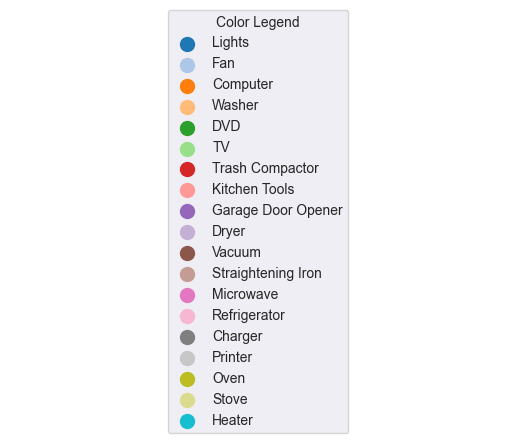

D:\Sustainable-Energy-Behavior\venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


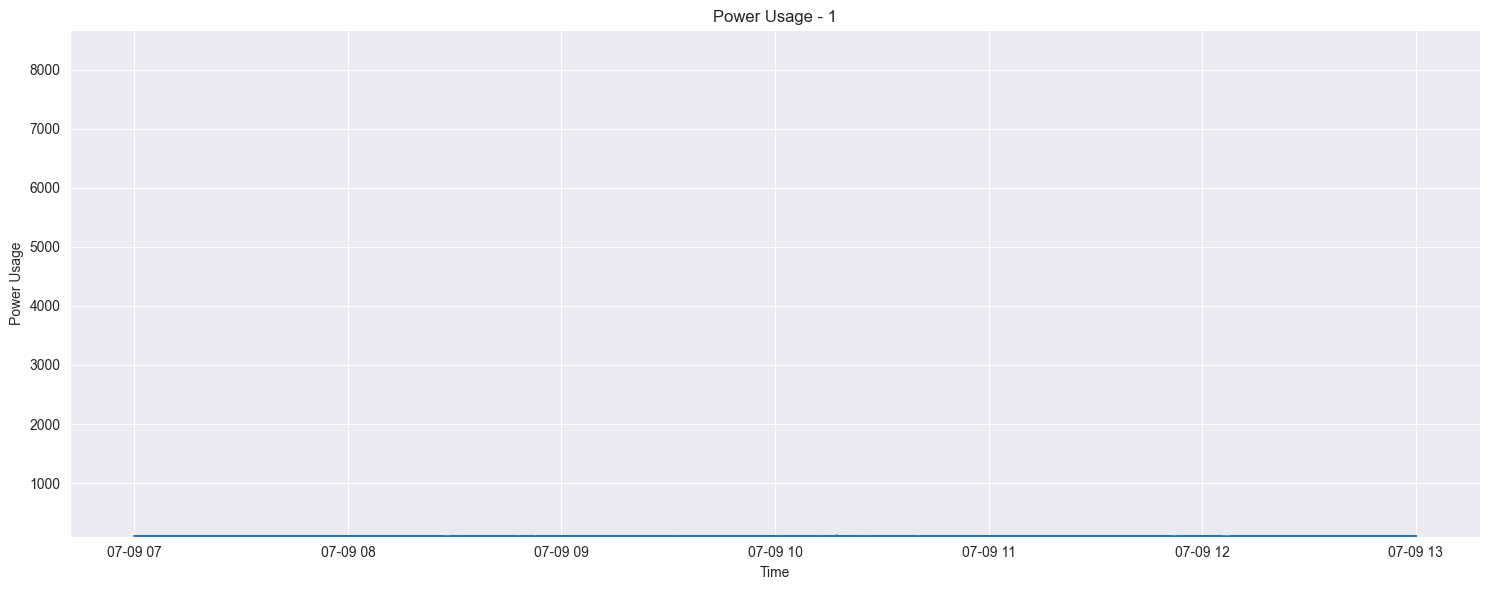

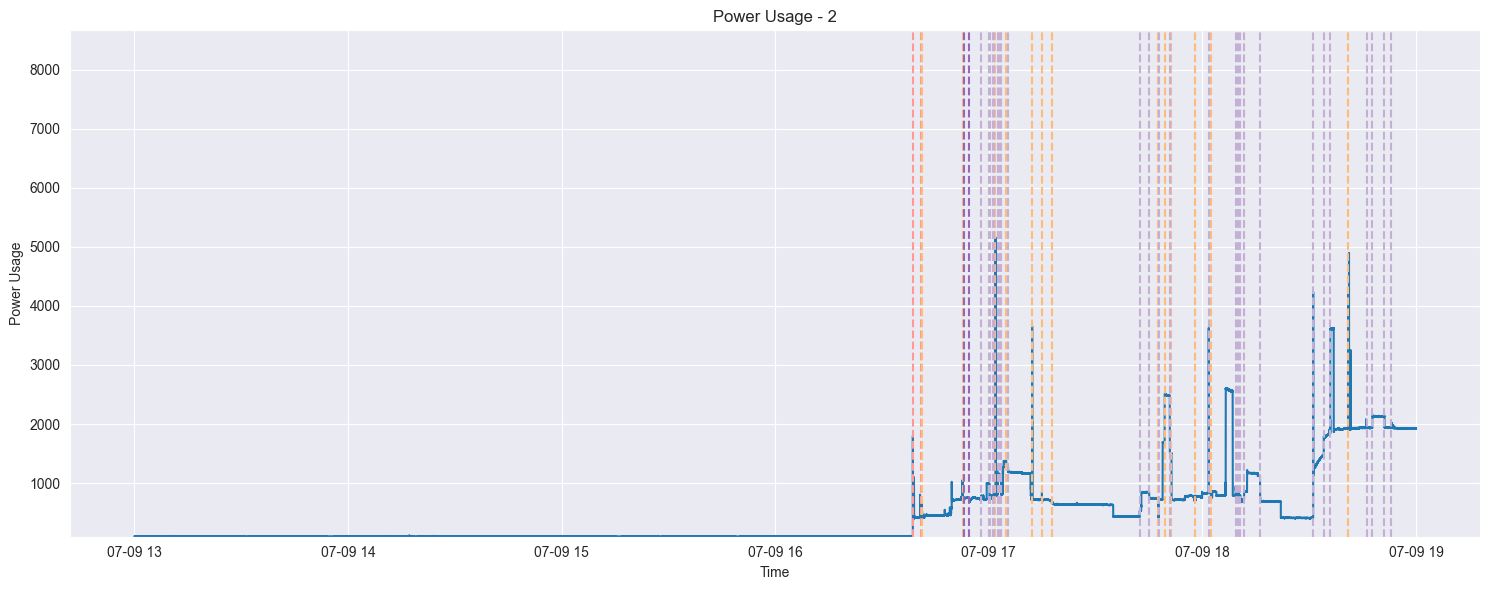

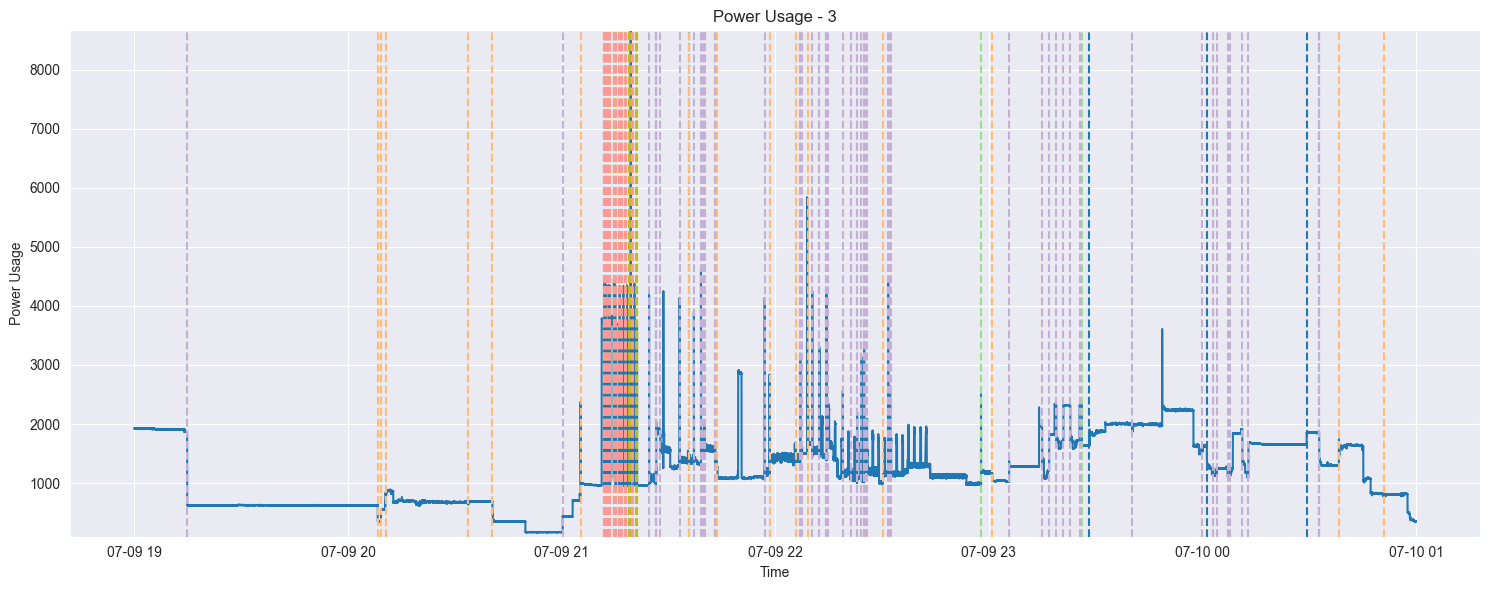

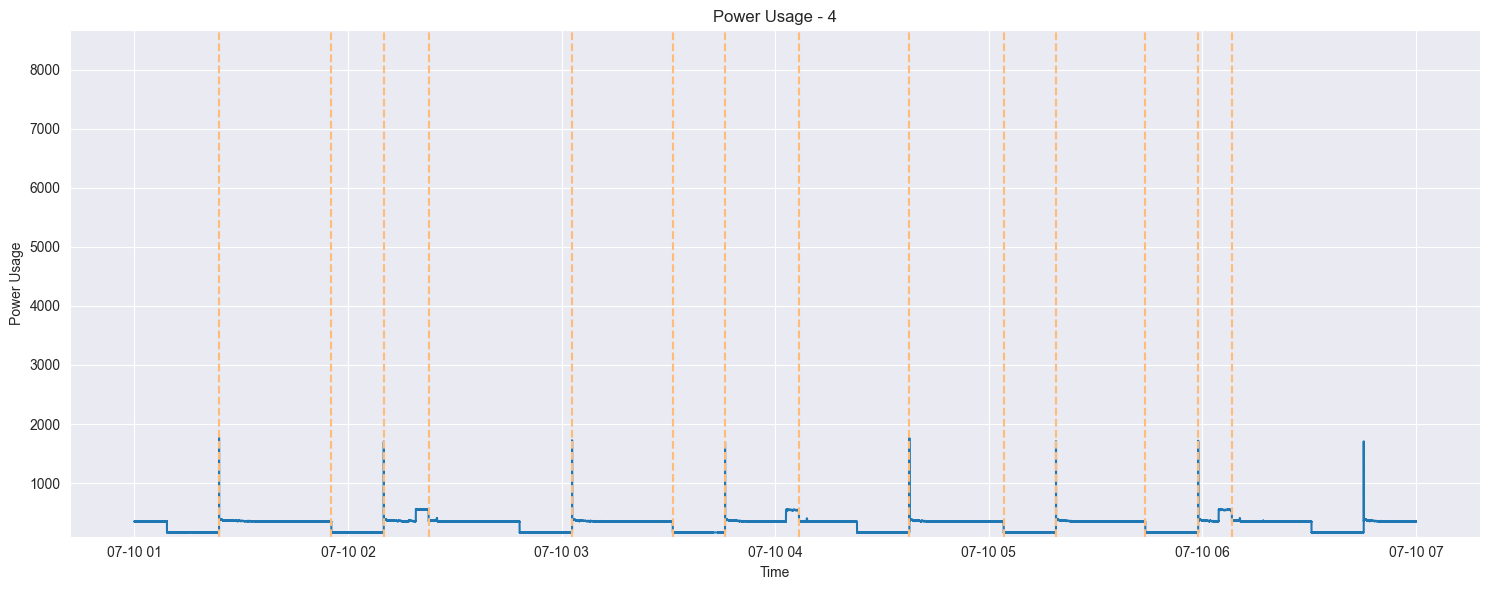

In [130]:
# Example data (replace this with your actual data)
power_usage = test["Phase1_actual"] + test["Phase2_actual"]
mod = power_usage.size % 4
power_usage = power_usage[:(power_usage.size - mod)]
TS1_real_modified = TS1_real[:(TS1_real.size - mod)]

class_names = {
    0: "Lights",
    1: "Fan",
    2: "Computer",
    3: "Washer",
    4: "DVD",
    5: "TV",
    6: "Trash Compactor",
    7: "Kitchen Tools",
    8: "Garage Door Opener",
    9: "Dryer",
    10: "Vacuum",
    11: "Straightening Iron",
    12: "Microwave",
    13: "Refrigerator",
    14: "Charger",
    15: "Printer",
    16: "Oven",
    17: "Stove",
    18: "Heater"
}
class_colors = {i: plt.cm.tab20(i) for i in range(19)}

# Create legend for color representation
fig, ax = plt.subplots()
for idx, color in class_colors.items():
    ax.scatter([], [], color=color, label=class_names[idx], s=100)

# Hide x and y axis
ax.axis('off')

# Display legend
ax.legend(title='Color Legend', loc='center', bbox_to_anchor=(0.5, 0.5))
plt.show()

# Split the data into 6-hour intervals
data_intervals = np.array(np.array_split(power_usage, 4))
time_intervals = np.array(np.array_split(TS1_real_modified, 4))
interval = data_intervals[0].size

min_value = min(power_usage)
max_value = max(power_usage)

# Plot power usage in 6-hour intervals
for i in range(4):
    plt.figure(figsize=(15, 6))
    plt.plot(time_intervals[i], data_intervals[i])
    plt.xlabel('Time')
    plt.ylabel('Power Usage')
    plt.title(f'Power Usage - {i + 1}')

    for start, end, pred_class, time in zip(events_start, events_end, final_pred, time_intervals[i]):
        if start in range(i * interval, (i + 1) * interval):
            start_index = int(start - i * interval)
            plt.axvline(x=time_intervals[i][start_index], color=class_colors[pred_class % 19], linestyle='--', label=f'Event {pred_class} start')

        if end in range(i * interval, (i + 1) * interval):
            end_index = int(end - i * interval)
            plt.axvline(x=time_intervals[i][end_index], color=class_colors[pred_class % 19], linestyle='--', label=f'Event {pred_class} end')

    plt.ylim(min_value, max_value)
    plt.tight_layout()
    plt.tight_layout()
    plt.show()